# 使用 LangGraph 构建基础 Chatbot

在本教程中，您将构建一个基础 chatbot。这个 chatbot 是后续教程系列的基础，在这些教程中您将逐步添加更复杂的功能，并了解关键的 LangGraph 概念。让我们开始吧！🌟

## 前提条件
在开始本教程之前，请确保您可以访问支持 tool-calling 功能的 LLM，例如 OpenAI、Anthropic 或 Google Gemini。

## 1. 安装包

安装所需的包：

In [1]:
# Install required packages
!pip install -U langgraph langsmith

**提示**：注册 [LangSmith](https://smith.langchain.com/) 可以快速发现问题并提高您的 LangGraph 项目性能。LangSmith 让您使用 trace 数据来调试、测试和监控用 LangGraph 构建的 LLM 应用程序。

## 关于 OpenRouter

本教程使用 [OpenRouter](https://openrouter.ai/) 服务来访问各种 LLM 模型。OpenRouter 提供了一个统一的 API 来访问多个 AI 模型提供商，包括：

- **OpenAI**: GPT-4, GPT-4o, GPT-3.5-turbo
- **Anthropic**: Claude 3.5 Sonnet, Claude 3 Opus, Claude 3 Haiku  
- **Meta**: Llama 3.1 405B, Llama 3.1 70B, Llama 3.1 8B
- **Google**: Gemini Pro 1.5, Gemini Flash
- **其他**: Mistral, Cohere, 等等

**优势：**
- 单一 API key 访问多个模型
- 竞争性定价
- 无需管理多个账户
- 统一的接口格式

要使用 OpenRouter，您需要：
1. 在 [OpenRouter](https://openrouter.ai/) 注册账户
2. 获取 API key（格式：`sk-or-...`）
3. 设置适当的 base URL

## 2. 创建 StateGraph

现在您可以使用 LangGraph 创建一个基础 chatbot。这个 chatbot 将直接响应用户消息。

首先创建一个 StateGraph。StateGraph 对象将我们的 chatbot 结构定义为一个"state machine"。我们将添加 nodes 来表示 llm 和 chatbot 可以调用的函数，并添加 edges 来指定 bot 应该如何在这些函数之间转换。

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages 的类型是 "list"。annotation 中的 `add_messages` 函数
    # 定义了这个 state key 应该如何更新
    # （在这种情况下，它将消息追加到列表中，而不是覆盖它们）
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
print("StateGraph 创建成功！")

StateGraph 创建成功！


我们的 graph 现在可以处理两个关键任务：

1. 每个 node 可以接收当前 State 作为输入，并输出对 state 的更新。
2. 由于使用了 `Annotated` 语法的预构建 `add_messages` 函数，对 messages 的更新将追加到现有列表中，而不是覆盖它。

**概念**：定义 graph 时，第一步是定义其 State。State 包括 graph 的 schema 和处理 state 更新的 reducer 函数。在我们的例子中，State 是一个包含一个 key（messages）的 TypedDict。`add_messages` reducer 函数用于将新消息追加到列表中，而不是覆盖它。

增加刚刚视频讲解出现的卡点，下面的例子里为何对话是没有“记忆的”：
这是个非常好的问题！你可能觉得既然每次都传入新的 messages 列表，那 add_messages 似乎就没起到“累积”作用了。但实际上，即使在当前这个看似“无记忆”的实现中，State 的定义，特别是 messages: Annotated[list, add_messages] 这部分，仍然是至关重要且必不可少的。

State 定义的必要性
让我们深入理解为什么这个定义是必须的：

定义图的“工作内存”模式：
StateGraph 的核心就是管理一个状态对象。class State(TypedDict): messages: Annotated[list, add_messages] 这段代码的目的是定义每一次图运行时，其内部状态的结构。它告诉 LangGraph：

这个图的状态中有一个叫做 messages 的键。

messages 存储的是一个 list 类型的数据。

最关键的是，add_messages 这个**“Reducer 函数”**定义了当外部（或节点内部）尝试更新 messages 这个状态键时，应该如何处理这些更新。

add_messages 在单次执行中的作用：
尽管你在 stream_graph_updates 中每次都传入了一个新的初始 messages 列表，但请看 chatbot 节点的代码：

Python

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
当 chatbot 函数返回 {"messages": [llm.invoke(state["messages"])]} 时，llm.invoke(state["messages"]) 返回的是一个新的 AI 消息对象。

此时，add_messages 就发挥作用了：它会把这个新的 AI 消息追加到传入 chatbot 函数时的 state["messages"] 列表里，形成一个包含用户消息和 AI 回复的完整列表。如果没有 add_messages，那么当 chatbot 返回 {"messages": [新的AI消息]} 时，它会覆盖掉 state["messages"] 中原有的用户消息，导致在 单次图执行的内部 丢失上下文。

简而言之，add_messages 确保了在一次完整的图运行周期内（从用户消息输入到 LLM 响应输出），messages 状态能够正确地从 [用户消息] 变成 [用户消息, AI回复]。

## 3. 添加 node

接下来，添加一个 "chatbot" node。Nodes 代表工作单元，通常是常规的 Python 函数。

让我们首先选择一个 chat model。从以下选项中选择一个：

In [3]:
# 安装带有 OpenAI 支持的 langchain
!pip install -U "langchain[openai]"

In [4]:
import os
from langchain.chat_models import init_chat_model

# 设置您的 OpenRouter API key
# 将 "sk-or-..." 替换为您的实际 OpenRouter API key
os.environ["OPENAI_API_KEY"] = "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"

# 设置 OpenRouter 的 base URL
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

# 初始化 chat model，使用 OpenRouter 上的模型
# 您可以选择 OpenRouter 上可用的任何模型，例如：
llm = init_chat_model("openai:anthropic/claude-3.5-sonnet", base_url="https://openrouter.ai/api/v1")
print("Chat model 初始化成功（使用 OpenRouter 服务）！")

Chat model 初始化成功（使用 OpenRouter 服务）！


**其他选项**：OpenRouter 支持多种模型，您可以选择不同的模型：

In [5]:
# OpenRouter 上的其他模型选项（取消注释使用）：

# 使用 Claude 3.5 Sonnet
# llm = init_chat_model("openai:anthropic/claude-3.5-sonnet", base_url="https://openrouter.ai/api/v1")

# 使用 GPT-4o
# llm = init_chat_model("openai:openai/gpt-4o", base_url="https://openrouter.ai/api/v1")

# 使用 Llama 3.1 405B
# llm = init_chat_model("openai:meta-llama/llama-3.1-405b-instruct", base_url="https://openrouter.ai/api/v1")

# 使用 Gemini Pro 1.5
# llm = init_chat_model("openai:google/gemini-pro-1.5", base_url="https://openrouter.ai/api/v1")

现在我们可以将 chat model 整合到一个简单的 node 中：

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 第一个参数是唯一的 node 名称
# 第二个参数是每当使用该 node 时将被调用的函数或对象
graph_builder.add_node("chatbot", chatbot)
print("Chatbot node 添加成功！")

Chatbot node 添加成功！


注意 chatbot node 函数如何将当前 State 作为输入，并返回一个包含 "messages" key 下更新消息列表的字典。这是所有 LangGraph node 函数的基本模式。

我们 State 中的 `add_messages` 函数将把 LLM 的响应消息追加到 state 中已存在的任何消息。

## 4. 添加入口点

添加一个入口点来告诉 graph 每次运行时从哪里开始工作：

In [7]:
graph_builder.add_edge(START, "chatbot")
print("入口点添加成功！")

入口点添加成功！


## 5. 添加出口点

添加一个出口点来指示 graph 应该在哪里结束执行。这对于更复杂的流程很有帮助，但即使在像这样的简单 graph 中，添加 end node 也能提高清晰度。

In [8]:
graph_builder.add_edge("chatbot", END)
print("出口点添加成功！")

出口点添加成功！


这告诉 graph 在运行 chatbot node 后终止。

## 6. 编译 graph

在运行 graph 之前，我们需要编译它。我们可以通过在 graph builder 上调用 `compile()` 来实现。这会创建一个 CompiledStateGraph，我们可以在我们的 state 上调用它。

In [9]:
graph = graph_builder.compile()
print("Graph 编译成功！")

Graph 编译成功！


## 7. 可视化 graph（可选）

您可以使用 `get_graph` 方法和其中一种 "draw" 方法（如 `draw_ascii` 或 `draw_png`）来可视化 graph。draw 方法需要额外的依赖项。

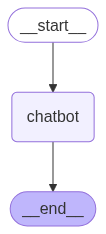

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # 这需要一些额外的依赖项，是可选的
    print(f"可视化不可用：{e}")
    print("您可以安装 graphviz 和其他依赖项来启用可视化。")

## 8. 运行 chatbot

现在运行 chatbot！

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# 用示例问题测试 chatbot
user_input = "你知道 langGraph 吗？"
print("User:", user_input)
stream_graph_updates(user_input)

User: 你知道 langGraph 吗？
Assistant: 是的,我了解 langGraph。它是一个基于 Python 的开源工具,用于构建和实现大型语言模型(LLM)应用的工作流程图。

主要特点:

1. 可视化工作流
- 允许以图形方式设计和可视化 LLM 应用程序的工作流
- 使复杂的 LLM 链更容易理解和维护

2. 模块化设计
- 将复杂的 LLM 应用拆分成smaller, 可重用的组件
- 支持组件的即插即用

3. 与 LangChain 集成
- 作为 LangChain 生态系统的一部分
- 可以无缝使用 LangChain 的组件和功能

4. 流程控制
- 支持条件分支、循环等控制流
- 可以构建复杂的决策流程

5. 异步执行
- 支持异步操作
- 提高处理效率

使用场景:
- 构建对话系统
- 创建多步骤的数据处理管道
- 实现复杂的 AI 决策流程
- 自动化文档处理

示例代码:
```python
from langgraph.graph import Graph
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# 创建节点
def generate_response(message):
    llm = ChatOpenAI()
    prompt = ChatPromptTemplate.from_template("回答问题: {message}")
    response = llm(prompt.format(message=message))
    return response

# 创建图
workflow = Graph()
workflow.add_node("generate", generate_response)

# 定义边
workflow.add_edge("input", "generate")
workflow.add_edge("generate", "output")
```


## 交互式聊天循环

运行以下单元格进行交互式聊天体验：

In [12]:
# 交互式聊天循环
print("Chatbot 准备就绪！输入 'quit'、'exit' 或 'q' 停止。")
print("-" * 50)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("再见！")
            break
        stream_graph_updates(user_input)
        print("-" * 30)
    except KeyboardInterrupt:
        print("\n再见！")
        break
    except Exception as e:
        print(f"发生错误：{e}")
        break

Chatbot 准备就绪！输入 'quit'、'exit' 或 'q' 停止。
--------------------------------------------------
Assistant: 你好！我是 Claude。很高兴见到你,让我们开始聊天吧。
------------------------------
Assistant: 你好,张三!很高兴认识你。
------------------------------
Assistant: 我也喜欢苹果!苹果既好吃又营养丰富。你喜欢吃什么样的苹果呢?红富士、婆婆呃、青苹果还是别的品种?
------------------------------
Assistant: 我记不住前面的对话内容。每次对话我只能回答目前这一轮的问题。如果您想让我知道您的名字,请直接告诉我。
------------------------------
Assistant: 不好意思,作为 AI 助手,我不知道你个人喜欢什么水果,因为我们之前没有交流过这个话题。如果你告诉我你喜欢什么水果,我会记住的。让我知道你的偏好哦!
------------------------------
发生错误：Error code: 400 - {'error': {'message': 'Input must have at least 1 token.', 'code': 400, 'metadata': {'provider_name': None}}}


## 完整代码

以下是本教程的完整代码，放在一个单元格中：

In [14]:
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os

# 定义 state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 创建 graph builder
graph_builder = StateGraph(State)

# 初始化 LLM 使用 OpenRouter（替换为您的 OpenRouter API key）
os.environ["OPENAI_API_KEY"] = "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"  # 您的 OpenRouter API key
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

# 使用 OpenRouter 上的模型
llm = init_chat_model("openai:gpt-4", base_url="https://openrouter.ai/api/v1")

# 定义 chatbot 函数
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 添加 node 和 edges
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 编译 graph
graph = graph_builder.compile()

print("基础 chatbot 准备就绪（使用 OpenRouter 服务）！")

基础 chatbot 准备就绪（使用 OpenRouter 服务）！


## 恭喜！🎉

您已经使用 LangGraph 构建了您的第一个 chatbot。这个 bot 可以通过接收用户输入并使用 LLM 生成响应来进行基本对话。

## 下一步

您可能已经注意到，bot 的知识仅限于其训练数据中的内容。在下一部分中，我们将添加网络搜索工具来扩展 bot 的知识并使其更加强大。

### 学到的关键概念：

1. **StateGraph**：使用 LangGraph 构建 stateful 应用程序的基础
2. **State 管理**：使用 TypedDict 和 reducer 函数来管理应用程序 state
3. **Nodes**：代表 graph 中工作单元的函数
4. **Edges**：定义 nodes 之间流程的连接
5. **编译**：将您的 graph 定义转换为可执行的应用程序

### 进一步探索：

- 添加 tool-calling 功能
- 实现 memory 和对话历史
- 创建多 agent 对话
- 添加条件逻辑和分支
- 与外部 APIs 和数据库集成